In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
import math
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools

### Create Environment

In [2]:
class SmartCharging(gym.Env):

    def __init__(self, render_mode=None):

        # action - kw: zero(0) - 0, low(1) - 7, medium(2) - 14, high(3) - 22
        self.actions_to_kw = [0, 7, 14, 22]
        self.action_space = spaces.Discrete(4)
        
        # average EV capacity 72 kWh: https://ev-database.org/cheatsheet/useable-battery-capacity-electric-car
        self.battery_capacity = 72
        # time steps: 0 - 2 p.m., 1 - 2:15 p.m., ... , 7 - 3:45 p.m., 8 - 4 p.m.
        self.time_step = 0
        self.observation_space = np.array([spaces.Box(0, self.battery_capacity, shape=(1,)), spaces.Box(0, 8, shape=(1,))])
        
        # 15 minute charging slots
        self.time_slot = 0.25
        # random start battery status in kWh to simulate energy left from previous shift
        self.battery_status = random.randint(0,self.battery_capacity)

    def _get_obs(self):
        #return {"battery status": self.battery_status, "time step": self.time_step}
        return np.array([self.battery_status, self.time_step])

    def step(self, action):

        terminated = False
        
        # loading time is over, determine demand and check if charged energy was sufficient
        if self.time_step == 8:
            
            energy_demand = np.random.normal(loc=30, scale=5)
            penalty_factor = 10
            
            # charged energy was not sufficient for the demand
            if energy_demand > self.battery_status:
                
                self.battery_status = 0
                # to really penalize running out of energy, make penalty as high as maximum charging costs times 10
                sum_of_time_coeffs = 2
                reward = (-1) * sum_of_time_coeffs * math.exp(self.actions_to_kw[3]) * penalty_factor
            # charged energy was sufficient
            else:
                
                self.battery_status -= energy_demand
                reward = 0

            terminated = True
            self.time_step += 1
        # loading time is not over, adjust the current state 
        else:
            
            charged_kWh = self.time_slot * self.actions_to_kw[action]
            time_coeff = self.time_slot 
            
            # if battery status would exceed capacity, it is only proportionally charged->adjust energy and time coefficient
            if self.battery_status + charged_kWh > self.battery_capacity:
                
                charged_kWh = self.battery_capacity - self.battery_status
                time_coeff = charged_kWh/self.actions_to_kw[action]
                
                
            self.battery_status += charged_kWh
            self.time_step += 1
            
            reward = (-1) * time_coeff * math.exp(self.actions_to_kw[action])
        
        return self._get_obs(), reward, terminated

    def reset(self, seed=None, options=None):
        
        # make random initialization of start battery status
        self.battery_status = random.randint(0,self.battery_capacity)
        self.time_step = 0
        
        return self._get_obs()
        

### Deep Q-Network

In [3]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(model_nr, lr, n_actions, input_dims):
    
    if model_nr == 1:
        # simpler network
        model = Sequential([
                    Dense(256, input_shape=(input_dims,)),
                    Activation('relu'),
                    Dense(256),
                    Activation('relu'),
                    Dense(n_actions)])
    else:
        # more complex network
        model = Sequential([
                    Dense(256, input_shape=(input_dims,)),
                    Activation('relu'),
                    Dense(512),
                    Activation('relu'),
                    Dense(256),
                    Activation('relu'),
                    Dense(n_actions)])

    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    return model


class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=10000, fname='dqn_model.h5', network_nr=1):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        self.q_eval = build_dqn(network_nr, alpha, n_actions, input_dims)
        # init target network
        self.q_target_network = build_dqn(network_nr, alpha, n_actions, input_dims)
        self.q_target_network.set_weights(self.q_eval.get_weights())

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                                          self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)

            q_eval = self.q_eval.predict(state)

            # determine next values with target network
            q_next = self.q_target_network.predict(new_state)

            q_target = q_eval.copy()

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indices] = reward + \
                                  self.gamma*np.max(q_next, axis=1)*done

            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                           self.epsilon_min else self.epsilon_min

    def update_target_network(self):
        self.q_target_network.set_weights(self.q_eval.get_weights())
    
    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model(self.model_file)
        

def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

In [4]:
def play_the_game(network_nr, learning_rate, gamma, epsilon, epsilon_end, n_games):

    env = SmartCharging()

    agent = Agent(gamma=gamma, epsilon=epsilon, alpha=learning_rate, input_dims=2,
                  n_actions=4, mem_size=1000000, batch_size=64, epsilon_end=0.0, 
                  fname=f'dqn_model_network{network_nr}_lr{learning_rate}_gamma{gamma}_epsilon{epsilon}.h5', 
                  network_nr=network_nr)

    #agent.load_model()
    scores = []
    eps_history = []

    for i in range(n_games):
        done = False
        score = 0
        observation = env.reset()
        print(observation)
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done = env.step(action)
            score += reward
            agent.remember(observation, action, reward, observation_, int(done))
            observation = observation_
            agent.learn()

        eps_history.append(agent.epsilon)
        scores.append(score)

        # every four games update target network weights
        if i % 4 == 0:
            agent.update_target_network()

        avg_score = np.mean(scores[max(0, i-100):(i+1)])
        print('episode: ', i,'score: %.2f' % score,
              ' average score %.2f' % avg_score)

        if i % 10 == 0 and i > 0:
            agent.save_model()

    filename = f'smartCharging_network{network_nr}_lr{learning_rate}_gamma{gamma}_epsilon{epsilon}.png'
    x = [i+1 for i in range(n_games)]
    plotLearning(x, scores, eps_history, filename)
    
    avg_score = np.mean(scores[-min(50, n_games):])
    filename = f'smartCharging_Scores_avg{avg_score}_network{network_nr}_lr{learning_rate}_gamma{gamma}_epsilon{epsilon}.txt'
    with open(filename, 'w') as file:
        for item in scores:
            file.write(f"{item}\n")
            
    
    return avg_score

C:\Users\Jonathan Langer\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[60  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  0 score: -602085.45  average score -602085.45
[5 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  1 score: -72594786882.37  average score -36297694483.91
[14  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
episode:  2 score: -71698258841.99  average score -48097882603.27
[62  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  9 score: -72594785786.74  average score -43825740824.36
[30  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━

episode:  10 score: -896528864.10  average score -39923085191.61
[5 0]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  11 scor

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  15 score: -5092206021.75  average score -41377102377.54
[59  0]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  19 score: -6273597754.89  average score -34148654449.99
[40  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━

episode:  20 score: -5214418685.28  average score -32770833699.29
[4 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  25 score: -6273597480.98  average score -27349344882.82
[17  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  29 score: -651802335.66  average score -24214712022.89
[13  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━

episode:  30 score: -7169825692.26  average score -23664876979.97
[8 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  35 score: -3421962262.22  average score -21100050125.38
[32  0]
1/1 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
episode:  39 score: -4603354269.76  average score -19443258954.35
[13  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━

episode:  40 score: -7169825692.26  average score -19143906923.57
[35  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  45 score: -3747863430.30  average score -17520037198.80
[0 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  49 score: -7169825692.26  average score -16550253270.28
[10  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

episode:  50 score: -7169825692.26  average score -16366323317.77
[69  0]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  51 s

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  55 score: -6029171604.86  average score -15299332035.32
[28  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  59 score: -2281308174.81  average score -14616141106.39
[31  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━

episode:  60 score: -6273597480.98  average score -14479378096.14
[1 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  65

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  69 score: -6518023356.60  average score -13131038112.74
[66  0]
1/1 ━━━━━━━━━━

episode:  70 score: -977703503.49  average score -12959864385.85
[5 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  75

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  79 score: -162950583.92  average score -1

episode:  80 score: -7169825692.26  average score -11772286927.14
[54  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  85 score: -2770159926.56  average score 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  89 score: -3584912846.13  average score -10872074227.09
[70  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━

episode:  90 score: -325901167.83  average score -10756182215.45
[51  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  99 score: -7169825692.26  average score 

episode:  100 score: -7169825692.26  average score -10247020376.62
[5 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  105 score: -2933110510.47  average score

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
episode:  109 score: -2770159926.56  average score -7159017124.51
[0 0]
1/1 ━━━━━━━━━━━━

episode:  110 score: -7169825692.26  average score -6511245242.39
[5 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  11

episode:  120 score: -5377369817.51  average score -4658644767.42
[29  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  129 score: -203689600.69  average score -4558603851.56
[50  0]
1/1 ━━━━━━━━━━━

episode:  130 score: -2444259855.36  average score -4576350955.72
[0 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  13

episode:  140 score: -4318191022.07  average score -4523106737.46
[47  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  14

episode:  150 score: -2810897846.69  average score -4494863833.16
[5 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  15

episode:  160 score: -7169825692.26  average score -4515431353.64
[21  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  16

episode:  170 score: -162950583.92  average score -4588033096.23
[61  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  17

episode:  180 score: -4073764597.88  average score -4815518564.86
[25  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  189

episode:  190 score: -5540319853.11  average score -4946201706.41
[56  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  199

episode:  200 score: -325901167.83  average score -4922807807.99
[56  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  20

episode:  210 score: -7006875108.35  average score -4885694295.79
[62  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  21

episode:  220 score: -4399665765.71  average score -4733230622.49
[50  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  22

episode:  230 score: -2607209342.64  average score -4870770519.55
[18  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  23

episode:  240 score: -4236715181.79  average score -4954262477.40
[14  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  249 score: -1466555255.24  average score

episode:  250 score: -5703270437.03  average score -4987739908.14
[7 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  25

episode:  260 score: -7169825692.26  average score -5025654147.48
[58  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  26

episode:  270 score: -4481141880.14  average score -4827209439.40
[19  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  27

episode:  280 score: -4481141880.14  average score -4679586012.76
[22  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  28

episode:  290 score: -2193.27  average score -4360945171.85
[15  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  299 score: -313.32  average score -40398

episode:  300 score: -3584913942.76  average score -4004390016.77
[33  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  30

episode:  310 score: -2193.27  average score -3708336350.62
[60  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  31

episode:  320 score: -2688686005.39  average score -3433256521.22
[52  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  32

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  329 score: -4481141880.14  average score

episode:  330 score: -2193.27  average score -3016199971.82
[61  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  33

episode:  340 score: -2688686005.39  average score -2645931220.81
[66  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  34

episode:  350 score: -783.31  average score -2271629014.31
[30  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  35

episode:  360 score: -2036.60  average score -1949761400.47
[47  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  36

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  369 score: -1723.28  average score -1614

episode:  370 score: -2193.27  average score -1588366179.05
[53  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
episode:  37

episode:  380 score: -4481141880.14  average score -1561745525.54
[8 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  38

episode:  390 score: -2193.27  average score -1535124878.22
[67  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  399 score: -2688686005.39  average score

episode:  400 score: -5377369817.51  average score -1614986835.67
[41  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  40

episode:  410 score: -5377369817.51  average score -1561745593.78
[23  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  41

episode:  420 score: -2688686005.39  average score -1685975252.30
[28  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  42

episode:  430 score: -1792458068.02  average score -1819078437.68
[13  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  43

episode:  440 score: -1792458068.02  average score -1872319721.45
[8 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  44

episode:  450 score: -6273597754.89  average score -1978802288.99
[27  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  459

episode:  460 score: -5377369817.51  average score -2076411326.56
[1 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  46

episode:  470 score: -2193.27  average score -2386985384.43
[62  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
episode:  47

episode:  480 score: -7169825692.26  average score -2369238312.07
[1 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
episode:  48

episode:  490 score: -783.31  average score -2342617692.68
[48  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  49

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
episode:  499 score: -4481141880.14  average score

episode:  500 score: -7169825692.26  average score -2493467962.83
[19  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
episode:  50

episode:  510 score: -7169825692.26  average score -2546709241.95
[8 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  519 score: -2688686005.39  average score

episode:  520 score: -2193.27  average score -2386985437.17
[23  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  52

episode:  530 score: -896230130.64  average score -2236135179.42
[38  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  53

episode:  540 score: -2193.27  average score -2351491238.16
[14  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  54

episode:  550 score: -3584913942.76  average score -2413606039.50
[71  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
episode:  55

episode:  560 score: -939.97  average score -2315997014.34
[7 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
episode:  56

episode:  570 score: -7169825692.26  average score -2209514488.68
[69  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  57

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
episode:  579 score: -896230130.64  average score 

episode:  580 score: -2688686005.39  average score -2165146741.09
[39  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  5

episode:  590 score: -939.97  average score -2076411286.23
[27  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  59

episode:  600 score: -3584913942.76  average score -2111905437.15
[41  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  60

episode:  610 score: -1253.30  average score -2023169988.50
[45  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  61

episode:  620 score: -1566.62  average score -1969928724.90
[32  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
episode:  62

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  629 score: -2193.27  average score -2005

episode:  630 score: -2193.27  average score -2005422902.18
[32  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  63

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  639 score: -1566.62  average score -1872

episode:  640 score: -2193.27  average score -1810204934.08
[44  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  64

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  649 score: -1096.63  average score -1748

episode:  650 score: -2193.27  average score -1730343032.46
[52  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  65

episode:  660 score: -313.32  average score -1730343040.22
[19  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  66

episode:  670 score: -2193.27  average score -1774710752.13
[21  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  67

episode:  680 score: -2688686005.39  average score -1792457860.17
[22  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
episode:  6

episode:  690 score: -5377369817.51  average score -1863446175.97
[42  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
episode:  69

episode:  700 score: -1253.30  average score -1827952023.50
[59  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  70

episode:  710 score: -2688686005.39  average score -2466847394.62
[22  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  71

episode:  720 score: -896230130.64  average score -2520088669.09
[55  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  72

episode:  730 score: -896230130.64  average score -2457973884.81
[27  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
episode:  73

episode:  740 score: -896230130.64  average score -2484594535.23
[71  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  74

episode:  750 score: -2688686005.39  average score -2413606160.49
[69  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  75

episode:  760 score: -2193.27  average score -2351491303.31
[70  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  76

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  769 score: -896230130.64  average score 

episode:  770 score: -2193.27  average score -2253882329.34
[16  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  77

episode:  780 score: -1253.30  average score -2280502948.73
[12  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  78

episode:  790 score: -6273597754.89  average score -2342617810.95
[70  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  79

episode:  800 score: -1253.30  average score -2174023436.27
[37  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  80

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  809 score: -2193.27  average score -1570

episode:  810 score: -2193.27  average score -1570625201.73
[18  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  81

episode:  820 score: -2193.27  average score -2111911580.67
[62  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  82

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  829 score: -2688686005.39  average score

episode:  830 score: -3584913942.76  average score -2156279267.77
[60  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  839 score: -2193.27  average score -2103

episode:  840 score: -6273597754.89  average score -2165152810.15
[54  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  84

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  849 score: -2193.27  average score -2111

episode:  850 score: -3584913942.76  average score -2147405750.20
[2 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  859

episode:  860 score: -1792458068.02  average score -2165152856.68
[29  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  86

episode:  870 score: -2193.27  average score -2111911622.55
[47  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  87

episode:  880 score: -896230130.64  average score -2076417463.87
[29  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
episode:  88

episode:  890 score: -896230130.64  average score -2014302646.64
[25  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  899 score: -2193.27  average score -1934

episode:  900 score: -6273597754.89  average score -1996552587.84
[50  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  90

episode:  910 score: -2193.27  average score -1827955269.37
[47  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  91

episode:  920 score: -2193.27  average score -1215680545.16
[25  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  92

episode:  930 score: -896230130.64  average score -1277795337.19
[63  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  93

episode:  940 score: -626.65  average score -1206812894.99
[67  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  94

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  949 score: -3584913942.76  average score

episode:  950 score: -783.31  average score -1295551283.55
[29  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  95

episode:  960 score: -3584913942.76  average score -1322171941.72
[53  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  96

episode:  970 score: -602947.09  average score -1348813379.32
[59  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  979

episode:  980 score: 0.00  average score -2076444172.72
[69  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  98

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  989 score: -896230130.64  average score -

episode:  990 score: -4481141880.14  average score -2040952930.68
[30  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  995

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  999 score: -2688686005.39  average score

episode:  1000 score: -1253.30  average score -2023205828.86
[13  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  100

episode:  1010 score: -3584913942.76  average score -2138561900.00
[56  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  10

episode:  1020 score: -2688986382.30  average score -2067585432.23
[32  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  10

episode:  1030 score: -2193.27  average score -2005488510.75
[16  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
episode:  103

episode:  1040 score: -903324.00  average score -2839655396.46
[72  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  10

episode:  1050 score: -1723.28  average score -2706570089.37
[6 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  10

episode:  1060 score: -3585815073.50  average score -2573514511.71
[48  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  10

episode:  1070 score: -1793659575.67  average score -2413817485.60
[10  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  10

episode:  1080 score: -903324.00  average score -1633031630.44
[17  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  10

episode:  1090 score: -1096.63  average score -1579864782.71
[2 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
episode:  1099 score: -897431638.29  average score

episode:  1100 score: -2193.27  average score -1544388454.24
[41  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  110

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  1109 score: -897732015.20  average score

episode:  1110 score: -1723.28  average score -1420191534.87
[5 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  11

episode:  1120 score: -2193.27  average score -1420239113.12
[65  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  11

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  1129 score: -2193.27  average score -136

episode:  1130 score: -2690187889.95  average score -1349259652.71
[44  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  11

episode:  1140 score: -2193.27  average score -497428970.55
[32  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  11

episode:  1150 score: -898332769.03  average score -488608949.83
[14  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  1159 score: -302570.18  average score -5

episode:  1160 score: -2193.27  average score -506367930.71
[61  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  11

episode:  1170 score: -1203700.92  average score -488659516.08
[39  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  117

episode:  1180 score: -903324.00  average score -453099910.15
[42  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  1189 score: -1879.94  average score -541

episode:  1190 score: -1793959952.58  average score -559543767.23
[39  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  11

episode:  1200 score: -1566.62  average score -515205792.50
[37  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  12

episode:  1210 score: -302570.18  average score -603944244.65
[64  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  12

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  1219 score: -897431638.29  average score

episode:  1220 score: -3586115450.42  average score -559576501.72
[24  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  12

episode:  1230 score: -2193.27  average score -586223937.01
[3 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  1239 score: -1793959952.58  average scor

episode:  1240 score: -74388444812.59  average score -1358186753.98
[56  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  12

episode:  1250 score: -156.66  average score -1411395307.93
[5 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  12

episode:  1260 score: -313.32  average score -1446844849.96
[56  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  126

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
episode:  1269 score: -2193.27  average score -142

episode:  1270 score: -2193.27  average score -1429056088.46
[54  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  12

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  1279 score: -313.32  average score -1429

episode:  1280 score: -1096.63  average score -1429029261.71
[30  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  12

episode:  1290 score: -2193.27  average score -1375758259.37
[10  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  129

episode:  1300 score: -1409.96  average score -1464475846.78
[21  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  13

episode:  1310 score: -2193.27  average score -1402352112.50
[35  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  13

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  1319 score: 0.00  average score -1473340

episode:  1320 score: -2193.27  average score -1464455036.34
[29  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  132

episode:  1330 score: -2193.27  average score -1499955161.68
[30  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  13

episode:  1340 score: -302570.18  average score -2165477163.86
[9 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
episode:  13

episode:  1350 score: -2193.27  average score -1384611005.27
[63  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  13

episode:  1360 score: -2036.60  average score -2050132993.48
[28  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  13

episode:  1370 score: -2193.27  average score -2112313290.15
[23  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  13

episode:  1380 score: -2193.27  average score -2059080992.06
[6 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  13

episode:  1390 score: -2193.27  average score -2050281817.46
[36  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  13

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  1399 score: -2193.27  average score -200

episode:  1400 score: -2193.27  average score -1970399088.34
[6 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  14

episode:  1410 score: -1723.28  average score -1934904926.56
[17  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  14

episode:  1420 score: -2690187889.95  average score -2600447736.07
[21  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  14

episode:  1430 score: -897431638.29  average score -2529477205.51
[5 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
episode:  14

episode:  1440 score: -2193.27  average score -1855072757.48
[16  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  14

episode:  1450 score: -897732015.20  average score -2591568205.30
[31  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
episode:  14

episode:  1460 score: -2193.27  average score -1828422400.90
[12  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  14

episode:  1470 score: -1566.62  average score -1792910365.47
[71  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  1

episode:  1480 score: -1203700.92  average score -1855048948.18
[19  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  14

episode:  1490 score: -602947.09  average score -1899372038.81
[69  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  14

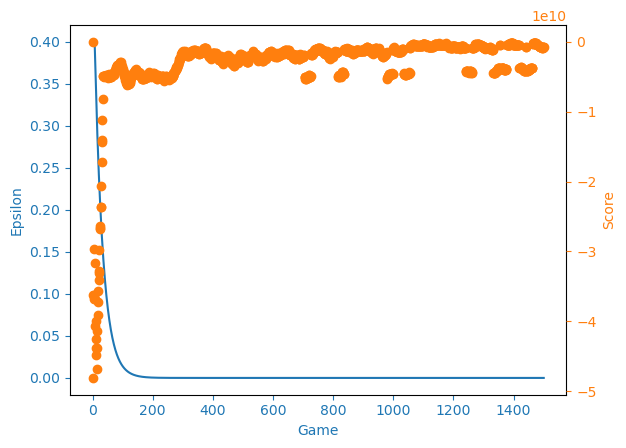

In [5]:
networks = [1]#[1,2]
learning_rates = [0.1]#[0.0005, 0.05, 0.1]
gammas = [0.7]#[0.95, 0.7]
epsilons = [0.4]#[0, 0.4]

max_avg_score = 0
max_parameters = 'empty'

n_games = 1500

for network, lr, gamma, epsilon in itertools.product(networks, learning_rates, gammas, epsilons):
    
    epsilon_end = 0
    if epsilon > 0:
        epsilon_end = 0.1
    
    avg_score_last_50 = play_the_game(network, lr, gamma, epsilon, epsilon_end, n_games)
    
    if max_avg_score == 0 or avg_score_last_50 > max_avg_score:
        max_avg_score = avg_score_last_50
        max_parameters = f"Network: {network}, Learning Rate: {lr}, Gamma: {gamma}, Epsilon: {epsilon}"
    
    
print(f'Max average score: {max_avg_score}')
print(f'with parameters: ' + max_parameters)

[37  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
training
[[37.  0.]]
[[0 0 0 1]]
[[42.5  1. ]]
[1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
training
[[37.  0.]]
[[0 0 0 1]]
[[42.5  1. ]]
[1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
training
[[37.  0.]]
[[0 0 0 1]]
[[42.5  1. ]]
[1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
training
[[48.  2.]]
[[0 0 0 1]]
[[53.5  3. ]]
[1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
training
[[55.25  4.  ]]
[[0 1 0 0]]
[[57.  5.]]
[1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
training
[[42.5  1. ]]
[[0 0 0 1]]
[[48.  2.]]
[1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
training
[[48.  2.]]
[[0 0 0 1]]
[[53.5  3. ]]
[1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
training
[[72.  5.]]
[[0 1 0 0]]
[[72.  6.]]
[1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
training
[[37.  0.]]
[[0 0 0 1]]
[[42.5  1. ]]
[1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
training
[[72.  7.]]
[[0 0 1 0]]
[[72.  8.]]
[1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
training
[[72.  5.]]
[[0 1 0 0]]
[[72.  6.]]
[1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
episode:  3 score: -2405208.57  average score -18597337582.46
[20  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  9 score: -71698256924.63  average score -36118297933.40


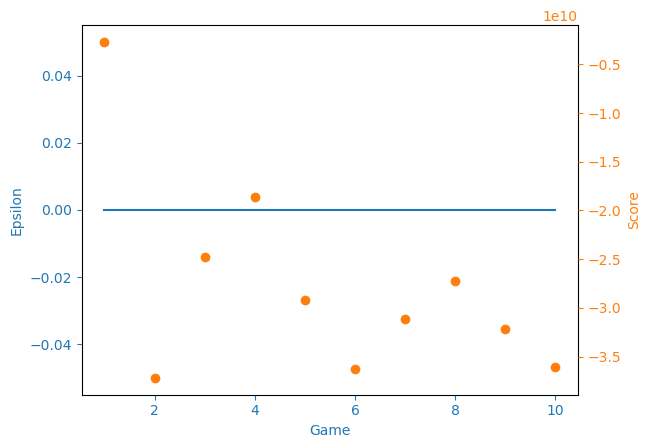

In [63]:

if __name__ == '__main__':
    
    env = SmartCharging()
    
    lr = 0.0005
    n_games = 10
    agent = Agent(gamma=0.99, epsilon=0.0, alpha=lr, input_dims=2,
                  n_actions=4, mem_size=1000000, batch_size=1, epsilon_end=0.0, network_nr=1 )

#     agent.load_model()
    scores = []
    eps_history = []

    for i in range(n_games):
        done = False
        score = 0
        observation = env.reset()#[0]
        print(observation)
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done = env.step(action)
            score += reward
            agent.remember(observation, action, reward, observation_, int(done))
            observation = observation_
            agent.learn()

        eps_history.append(agent.epsilon)
        scores.append(score)
        
        if i % 3 == 0:
            agent.update_target_network()
            
        avg_score = np.mean(scores[max(0, i-100):(i+1)])
        print('episode: ', i,'score: %.2f' % score,
              ' average score %.2f' % avg_score)

        if i % 10 == 0 and i > 0:
            agent.save_model()

    filename = 'smartCharging.png'

    x = [i+1 for i in range(n_games)]
    plotLearning(x, scores, eps_history, filename)

In [44]:
# check target network seltener updaten?
# zweites modifiziertes Model
# Algo für automatisierung verschiedene Parameter (Epsilons, Gamma)

# Q-Learning implementieren

[70  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  0 score: -171800.61  average score -171800.61
[21  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
episode:  1 score: -2405208.57  average score -1288504.59
[7 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
episode:  2 score: -2405208.

episode:  10 score: -72594485683.73  average score -13548161741.35
[6 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  19 score: -302570.18  average score -14937106884.79
[66  0]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━

episode:  20 score: -940.22  average score -14225816125.53
[32  0]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  21 score: -1371.54  average score -13579188182.16

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
episode:  29 score: -896228916.51  average score -12452593658.05
[20  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━

episode:  30 score: -2193.27  average score -12050897159.18
[14  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
episode:  39 score: -71698256924.63  average score -18418863343.18
[0 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━

episode:  40 score: -71698259115.90  average score -19718360801.05
[1 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  49 score: -1718006.12  average score -17603226874.60
[1 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━

episode:  50 score: -71700662131.20  average score -18663960899.24
[55  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  59 score: -2104557.75  average score -15864646656.19
[69  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━

episode:  60 score: -257700.92  average score -15604574706.10
[32  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  69 score: -1975707.29  average score -13598512764.75
[2 0]
1/1 ━━━━━━━━━━━━━━━

episode:  70 score: -71700662131.20  average score -14416852896.67
[45  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  79 score: -1975707.04  average score -12795147003.65
[47  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━

episode:  80 score: -2147507.65  average score -12637208738.27
[28  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  89 score: -1803906.43  average score -11383609888.19
[51  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━

episode:  90 score: -897559666.28  average score -11268378567.08
[52  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  99 score: -2405208.57  average score -10

episode:  100 score: -2405208.57  average score -10152885906.16
[70  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  109 score: -2405208.57  average score -1

episode:  110 score: -71700662131.20  average score -10816076658.13
[28  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  11

episode:  120 score: -2405208.57  average score -8615208455.59
[12  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  12

episode:  130 score: -2405208.57  average score -7874479785.62
[33  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
episode:  139 score: -2233407.96  average score -4

episode:  140 score: -898332769.03  average score -4287760635.65
[39  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  14

episode:  150 score: -2405208.57  average score -2868127668.16
[24  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
episode:  15

episode:  160 score: -1803906.43  average score -3578039891.74
[31  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  16

episode:  170 score: -71700662131.20  average score -4287992513.99
[10  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  17

episode:  180 score: -2405208.57  average score -3578153005.27
[24  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  189 score: -1566.62  average score -4279

episode:  190 score: -71698259115.90  average score -4988967050.07
[9 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  19

episode:  200 score: -2193.27  average score -6399683420.98
[60  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  209 score: -2193.27  average score -7819

episode:  210 score: -71698259115.90  average score -8529126440.11
[63  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
episode:  219 score: -1010151.32  average score -9

episode:  220 score: -2.00  average score -9238830678.43
[68  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
episode:  229 score: -71698256924.63  average scor

episode:  230 score: -71698256924.63  average score -12788030760.16
[15  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  239 score: -1632105.81  average score -1

episode:  240 score: -2061607.34  average score -14216581617.89
[9 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  24

episode:  250 score: -2405208.57  average score -15627478511.80
[41  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
episode:  259

episode:  260 score: -1288504.59  average score -14917549703.50
[43  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  26

episode:  270 score: -2405208.57  average score -14917529291.54
[14  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  27

episode:  280 score: -2405208.57  average score -14207620044.69
[64  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  28

episode:  290 score: -429501.53  average score -14207700996.47
[24  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  29

episode:  300 score: -2405208.57  average score -13498011820.77
[30  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
episode:  30

episode:  310 score: -2405208.57  average score -11368522024.25
[24  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  31

episode:  320 score: -2405208.57  average score -9239050300.42
[6 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  32

episode:  330 score: -2405208.57  average score -6399727146.61
[23  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  33

episode:  340 score: -429501.53  average score -4261287453.96
[35  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  34

episode:  350 score: -2405208.57  average score -4261247480.55
[56  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  35

episode:  360 score: -71698256924.63  average score -4971087837.10
[32  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  36

episode:  370 score: -71698256924.63  average score -7100538315.47
[47  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  379 score: -2.00  average score -9230010

episode:  380 score: -2.00  average score -9229996448.32
[12  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  389 score: -2193.27  average score -9939

episode:  390 score: -71698259115.90  average score -10649552206.11
[66  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode:  39

episode:  400 score: -2193.27  average score -9939493459.29
[72  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  409 score: -2193.27  average score -9939355852.32
[10  0]
1/1 ━━━━━━━━━━━━━━━━

episode:  410 score: -71698259115.90  average score -10649215792.00
[53  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
episode:  419 score: -71698259115.90  average scor

episode:  420 score: -71698259115.90  average score -12778677508.13
[44  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  42

episode:  430 score: -71698259115.90  average score -14198233388.71
[5 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
episode:  43

episode:  440 score: -71698259115.90  average score -16327671307.95
[59  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  44

episode:  450 score: -1632105.81  average score -15617742996.64
[38  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  45

episode:  460 score: -859003.06  average score -15617770212.55
[68  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  46

episode:  470 score: -1288504.59  average score -13488306126.21
[1 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  47

episode:  480 score: -2405208.57  average score -12068726622.27
[31  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  489

episode:  490 score: -2405208.57  average score -10649164082.20
[60  0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
episode:  499

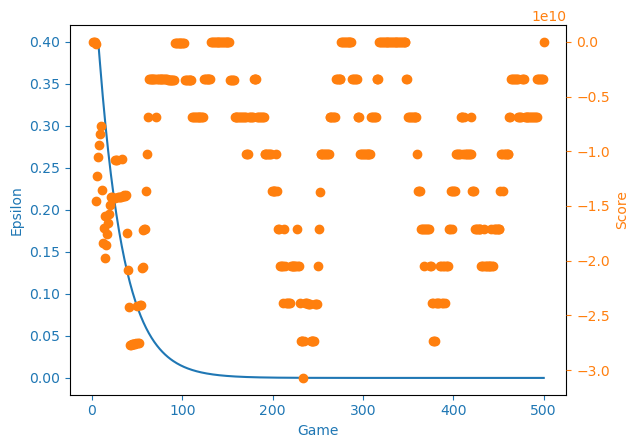

In [45]:

if __name__ == '__main__':
    
    env = SmartCharging()
    
    lr = 0.0005
    n_games = 500
    agent = Agent(gamma=0.99, epsilon=0.4, alpha=lr, input_dims=2,
                  n_actions=4, mem_size=1000000, batch_size=64, epsilon_end=0.0)

#     agent.load_model()
    scores = []
    eps_history = []

    for i in range(n_games):
        done = False
        score = 0
        observation = env.reset()#[0]
        print(observation)
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done = env.step(action)
            score += reward
            agent.remember(observation, action, reward, observation_, int(done))
            observation = observation_
            agent.learn()

        eps_history.append(agent.epsilon)
        scores.append(score)
        if i % 3 == 0:
            agent.update_target_network()
        avg_score = np.mean(scores[max(0, i-100):(i+1)])
        print('episode: ', i,'score: %.2f' % score,
              ' average score %.2f' % avg_score)

        if i % 10 == 0 and i > 0:
            agent.save_model()

    filename = 'smartCharging.png'

    x = [i+1 for i in range(n_games)]
    plotLearning(x, scores, eps_history, filename)